In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

## Data

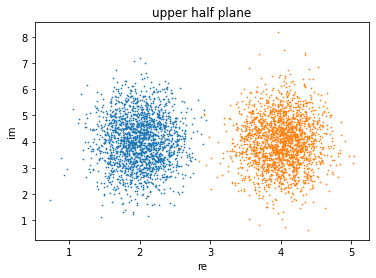

In [2]:
# generate two random data clouds/blobs in the upper half plane that are well-separated by a geodesic

N = 2000

mean1 = [2, 4]
cov1 = [[.1, 0], [0, 1]]
dist1 = np.random.multivariate_normal(mean=mean1, cov=cov1, size=N)
x1, y1 = dist1[:, 0], dist1[:, 1].clip(min=1e-5)

mean2 = [4, 4]
cov2 = [[.1, 0], [0, 1]]
dist2 = np.random.multivariate_normal(mean=mean2, cov=cov2, size=N)
x2, y2 = dist2[:, 0], dist2[:, 1].clip(min=1e-5)

plt.scatter(x1, y1, s=0.5)
plt.scatter(x2, y2, s=0.5)
plt.xlabel("re")
plt.ylabel("im")
plt.title("upper half plane")
plt.show()

In [3]:
def upper_plane_to_disc(x, y):
    z = x + 1j * y
    w = (z - 1j)/(z + 1j)
    return w.real, w.imag

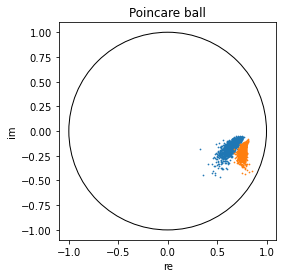

In [4]:
# generate synthetic data clouds in the Poincare ball that are well-separated by a geodesic

x1, y1 = upper_plane_to_disc(x1, y1)
x2, y2 = upper_plane_to_disc(x2, y2)

circle1 = plt.Circle((0, 0), 1, fill=False)
plt.scatter(x1, y1, s=0.5)
plt.scatter(x2, y2, s=0.5)
plt.gca().add_patch(circle1)
plt.xlabel("re")
plt.ylabel("im")
plt.title("Poincare ball")
plt.gca().set_aspect(1)
plt.show()

In [5]:
X1 = np.stack((x1, y1), axis=-1)
label1 = np.array([0.0] * N)

X2 = np.stack((x2, y2), axis=-1)
label2 = np.array([1.0] * N)

X = np.concatenate((X1, X2))
label = np.concatenate((label1, label2))

In [6]:
X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.25, stratify=label)

In [7]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], label_train[i]])
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=50)

test_data = []
for i in range(len(X_test)):
    test_data.append([X_test[i], label_test[i]])
testloader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=50)

## Geometry

The following notation and formulas describe the relevant aspects of the Poincaré ball model:
* Euclidean dot product and $L_2$ norm: $\langle \cdot, \cdot\rangle$ and $\|\cdot\|$
* Manifold: $\mathbb{B}^m := \{x \in \mathbb{R}^m \mid \|x\| < 1\}$
* Conformal factor: $\lambda_x = \frac{2}{1-\|x\|^2}$
* Riemannian metric: $g_x^{\mathbb{B}^m} := \lambda_x^2 g^{\mathbb{R}^m} = \lambda_x^2 I_m$
* Riemannian distance: $d_{\mathbb{B}^m}(x, y) = \text{arcosh}\left(1 + 2\frac{\|x - y\|^2}{(1 - \|x\|^2)(1 - \|y\|^2)}\right)$
* Moebius addition: $x \oplus y := \frac{(1 + 2\langle x, y \rangle + \|y\|^2)x + (1 - \|x\|^2)y}{1 + 2\langle x, y \rangle + \|x\|^2 \|y\|^2}$
* Exponential map: $\text{Exp}_x(v) = x \oplus\left(\tanh\left(\frac{\|v\|}{1-\|x\|^2}\right)\frac{v}{\|v\|}\right)$
* Logarithmic map: $\text{Log}_x(y) = (1 - \|x\|^2) \text{arctanh}(\|(-x) \oplus y\|) \frac{(-x) \oplus y}{\|(-x) \oplus y\|}$
* Parallel transport from $0$ to $x$: $P_{0 \to x}(v) = \frac{\lambda_0}{\lambda_x}v = (1 - \|x\|^2)v$
    * Another formula for Moebius addition: $x \oplus y = \text{Exp}_x \circ P_{0 \to x} \circ \text{Log}_0 (y)$
* Manifold gradient: $\nabla^{\mathbb{B}^m}f(x) = \left(g_x^{\mathbb{B}^m}\right)^{-1} \nabla^{\mathbb{R}^m}f(x) = \lambda_x^{-2} \nabla^{\mathbb{R}^m}f(x)$

In [8]:
minimum_norm = 1e-10
epsilon = 1e-5

def proj(p):
    """
    Project a point outside the disk into the disk
    """
    norm = torch.clamp_min(torch.norm(p, dim=-1, keepdim=True), minimum_norm)
    maxnorm = 1 - epsilon
    cond = norm > maxnorm
    projected = p / norm * maxnorm
    return torch.where(cond, projected, p)

def lambda_p(p):
    square_norm = torch.norm(p, dim=-1, keepdim=True)
    return 2 / torch.clamp_min(1 - square_norm, minimum_norm) # when square_norm ~ 1

def mobius_add(p, q):
    p2 = p.pow(2).sum(dim=-1, keepdim=True)
    q2 = q.pow(2).sum(dim=-1, keepdim=True)
    pq = (p * q).sum(dim=-1, keepdim=True)
    num = (1 + 2 * pq + q2) * p + (1 - p2) * q
    denom = 1 + 2 * pq + p2 * q2
    return num / torch.clamp_min(denom, minimum_norm) # when denom ~ 0

def expmap(p, v):
    v_norm = torch.clamp_min(torch.norm(v, dim=-1, keepdim=True), minimum_norm) # when v ~ 0
    rhs = torch.tanh(0.5 * lambda_p(v) * v_norm) * v / v_norm
    return mobius_add(p, rhs)

def expmap0(v):
    v_norm = torch.clamp_min(torch.norm(v, dim=-1, keepdim=True), minimum_norm) # when v ~ 0
    return torch.tanh(v_norm) * v / v_norm

def logmap(p, q):
    square_norm = torch.norm(p, dim=-1, keepdim=True)
    sub = mobius_add(-p, q)
    sub_norm = torch.clamp_min(torch.norm(sub, dim=-1, keepdim=True), minimum_norm) # when sub_norm ~ 0
    return (1 - square_norm) * torch.atanh(sub_norm) * sub / sub_norm

def logmap0(q):
    q_norm = torch.clamp_min(torch.norm(q, dim=-1, keepdim=True), minimum_norm)
    return torch.atanh(q_norm) * q / q_norm

## Model Definition

In [9]:
class PoincareBallLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # naive initialization
        self.weight = nn.Parameter(torch.zeros(2, 2))
        self.bias = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        # y = Exp_0 o W o Log_0 (x)
        v = logmap0(x)
        u = v @ self.weight.transpose(-1, -2)
        y = expmap0(u)

        # z = Exp_y o P_{0 -> y} (b) = y oplus Exp_0 (b)
        hyp_bias = expmap0(self.bias)
        z = mobius_add(y, hyp_bias)
        # z = proj(z) # is mobius_addition guaranteed to not go outside the circle?

        return z

class PoincareBallSigmoid(torch.nn.Module):
    def __init__(self):
        super().__init__()

    # y = Exp_0 o sigmoid o Log_0 (x)
    def forward(self, x):
        v = logmap0(x)
        h = torch.sigmoid(v)
        y = expmap0(h)

        return y

class EuclideanPlaneToPoincareBall(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, v):
        x = expmap0(v)
        return x

class PoincareBallToEuclideanPlane(torch.nn.Module):
    def __init__(self):
        super().__init__()
            
    def forward(self, x):
        v = logmap0(x)
        return v

In [10]:
class PoincareBallLogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.poincarelinear = PoincareBallLinear()
        self.linearproj = PoincareBallToEuclideanPlane()
        self.euclidlinear = torch.nn.Linear(2, 1)

    def forward(self, x):
        z = self.poincarelinear(x)
        u = self.linearproj(z)
        h = self.euclidlinear(u)
        y_pred = torch.sigmoid(h)
        return y_pred

**Question**: How is the implemented model different from the following model?

```
class PoincareBallLogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bias = nn.Parameter(torch.Tensor(1))
        self.weight = nn.Parameter(torch.Tensor(1,2))

    def forward(self, x):
        v = logmap0(x)
        h = v @ self.weight.transpose(-1, -2) + self.bias
        y_pred = torch.sigmoid(h)
        return y_pred
```

## Model Training

In [11]:
torch.autograd.set_detect_anomaly(True) # raise an error if/when a nan arises; detects gradient explosion/vanishing

In [12]:
model = PoincareBallLogisticRegression().double()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [13]:
n_epochs = 200

for epoch in range(n_epochs):
    for i, (points, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = model(points)
        labels = labels.reshape(-1, 1) # needs to be fixed
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        correct = 0
        total = 0

        for points, labels in testloader:
            outputs = model(points)
            predicted = (outputs.data > 0.5).float()
            labels = labels.reshape(-1, 1)

            total += labels.size(0)
            correct+= (predicted == labels).sum()
        accuracy = 100 * correct/total
        print("Epoch: {}. Loss: {}. Accuracy: {:.3f}%.".format(epoch, loss.item(), accuracy.item()))

Epoch: 0. Loss: 0.7197161750779868. Accuracy: 50.000%.
Epoch: 50. Loss: 0.565610785757696. Accuracy: 95.100%.
Epoch: 100. Loss: 0.10842566645948314. Accuracy: 99.600%.
Epoch: 150. Loss: 0.025124753733050856. Accuracy: 99.600%.


## Model Inspection

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

poincarelinear.weight tensor([[-0.1087, -0.0824],
        [ 1.6541, -0.9387]], dtype=torch.float64)
poincarelinear.bias tensor([ 0.6001, -4.4148], dtype=torch.float64)
euclidlinear.weight tensor([[-1.1787,  4.2959]], dtype=torch.float64)
euclidlinear.bias tensor([-1.5962], dtype=torch.float64)


## TODO

* Generate and train on more meaningful data
* Improve training performance reporting (can copy boilerplate from NB08)
* Demonstrate deeper examples of hyperbolic neural networks
* Initialize weights with `xavier_uniform`
* Build a Hyperbolic Neural Network Playground a la [Google](https://playground.tensorflow.org/)